In [82]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout
import seaborn as sns
from tensorflow.keras.optimizers import Adam,RMSprop,Adagrad
from tensorflow.keras.callbacks import EarlyStopping

In [83]:
df = pd.read_excel('C:/Users/supri/dataset1.xlsx', header=0, index_col=0, parse_dates=True)

In [84]:
df = df.loc[df['Product Category'] == 'Furniture']

In [85]:
df = df['Sales'].resample('M').sum().reset_index()

<Axes: xlabel='Order Date', ylabel='Sales'>

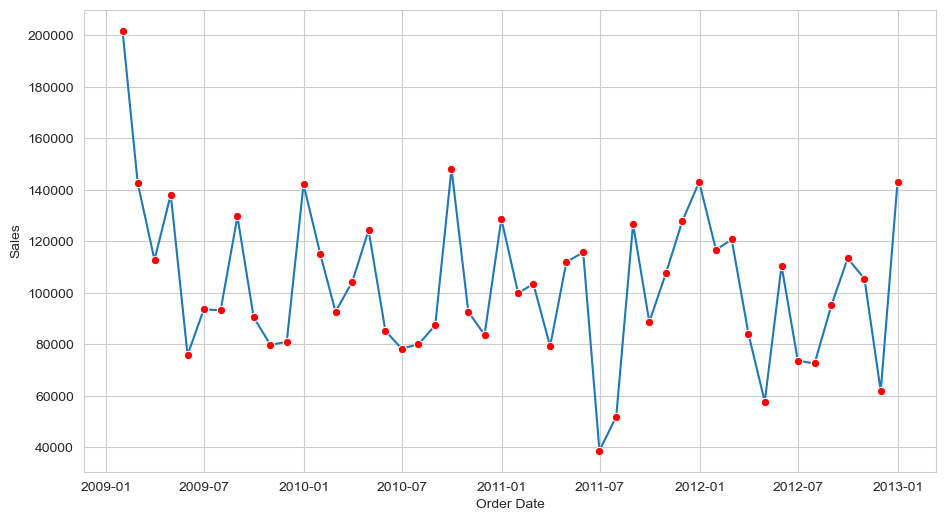

In [86]:
fig=plt.figure(figsize=(11,6))
sns.set_style('whitegrid')
sns.lineplot(x=df['Order Date'],y=df['Sales'],marker='o',markerfacecolor='red')

**Check Stationary**

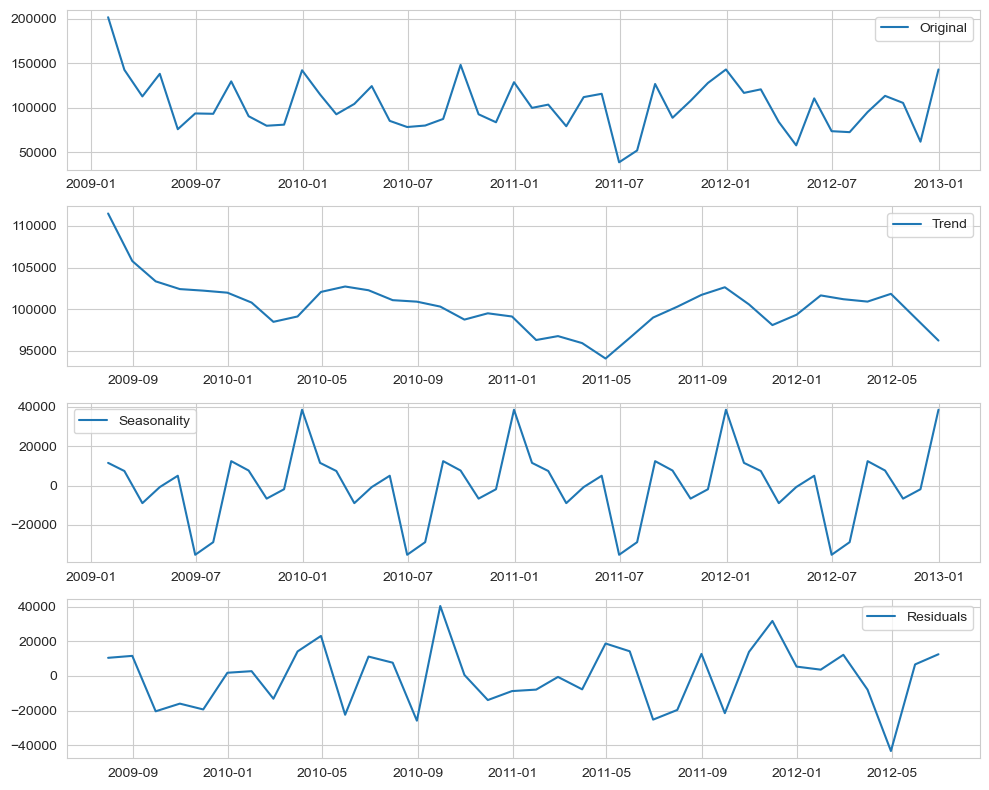

In [87]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose

# Assuming y is the resampled sales data as calculated earlier
decomposition = seasonal_decompose(df.set_index('Order Date'), model='additive')

# Plot the original data, trend, seasonal and residual components
plt.figure(figsize=(10, 8))
plt.subplot(411)
plt.plot(df.set_index('Order Date'), label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(decomposition.trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(decomposition.seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(decomposition.resid, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()
plt.show()

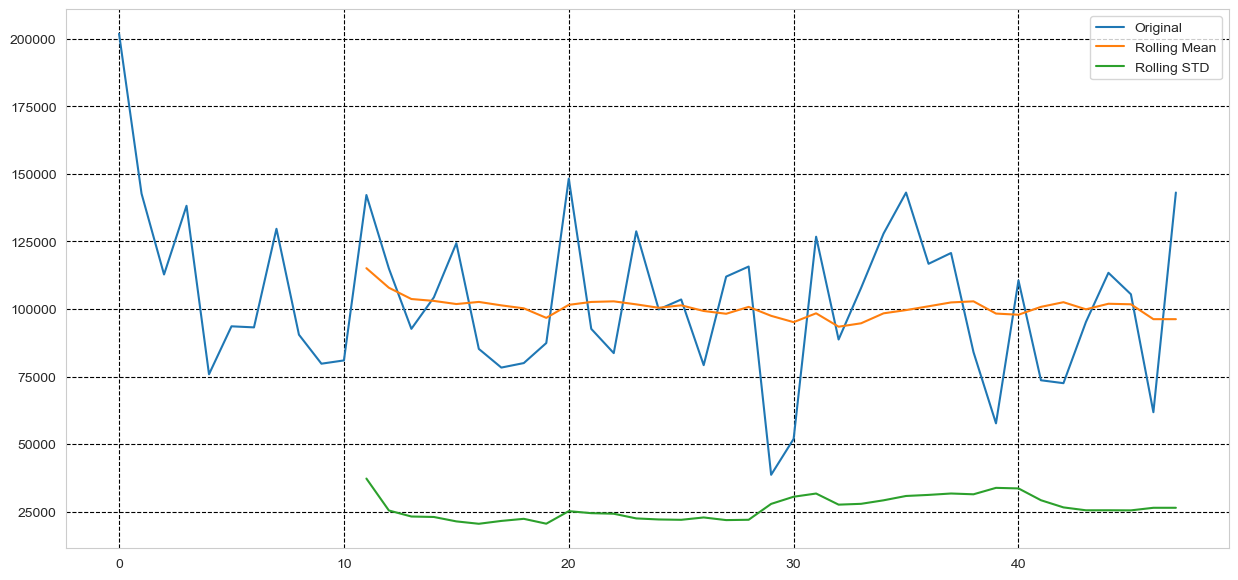

In [88]:
#plotting rolling mean and standard deviation.

rm = df['Sales'].rolling(window=12).mean()
rs = df['Sales'].rolling(window=12).std()
    
fig, ax = plt.subplots(figsize=(15,7))
ax.plot(df['Sales'], label='Original')
ax.plot(rm, label='Rolling Mean')
ax.plot(rs,  label='Rolling STD')
    
ax.legend(loc='upper right')
plt.grid(linestyle="--", color='black')
plt.show()

The data is stationary after 0 differencing.
ADF Statistic: -3.7132541936574657
p-value: 0.003930537834504123
Critical Values:
	1%: -3.601
	5%: -2.935
	10%: -2.606


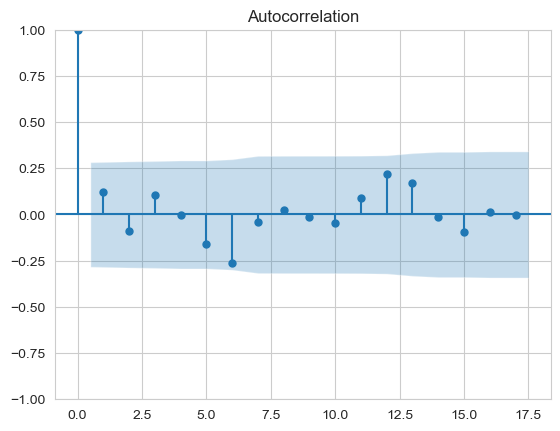

C:\Users\supri\.conda\envs\pyth_tensorflow\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


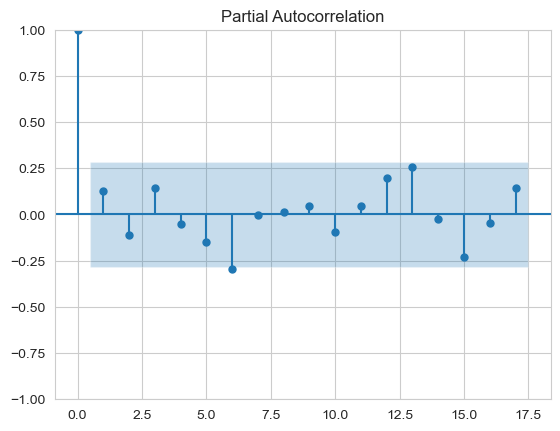

In [89]:
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt

temp_df=df.set_index('Order Date')

# perform differencing until data becomes stationary
d = 0
result = adfuller(temp_df['Sales'])
while result[1] > 0.05:
    d += 1
    diff_data = temp_df['Sales'].diff(periods=1).dropna()
    result = adfuller(diff_data)

# print final ADF test results
print(f"The data is stationary after {d} differencing.")
print('ADF Statistic:', result[0])
print('p-value:', result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))


plot_acf(df.set_index('Order Date'))
plt.show()

plot_pacf(df.set_index('Order Date'))
plt.show()

In [90]:
from statsmodels.tsa.stattools import kpss

temp_df=df.set_index('Order Date')
# Perform KPSS test
kpss_stat, p_value, lags, critical_values = kpss(temp_df['Sales'])

# Print the results
print(f'KPSS Statistic: {kpss_stat}')
print(f'p-value: {p_value}')
print(f'Critical Values:')
for key, value in critical_values.items():
    print(f'    {key}: {value}')

# Check if the data is stationary or not based on the p-value
alpha = 0.05
if p_value < alpha:
    print('The data is not stationary.')
else:
    print('The data is stationary.')


KPSS Statistic: 0.2863645787224248
p-value: 0.1
Critical Values:
    10%: 0.347
    5%: 0.463
    2.5%: 0.574
    1%: 0.739
The data is stationary.


C:\Users\supri\.conda\envs\pyth_tensorflow\lib\site-packages\statsmodels\tsa\stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(


In [91]:
# Prepare the data
scaler = MinMaxScaler()
sales_data_scaled = scaler.fit_transform(temp_df['Sales'].values.reshape(-1,1))

In [92]:
train_size = int(len(sales_data_scaled)*0.7)
test_size = len(sales_data_scaled) - train_size
train_data = sales_data_scaled[:train_size]
test_data = sales_data_scaled[train_size:]
look_back=3
def create_dataset(dataset, lookback=1):
    X, Y = [], []
    for i in range(lookback, len(dataset)):
        X.append(dataset[i-lookback:i, :])
        Y.append(dataset[i, 0])
    return np.array(X), np.array(Y)

if len(test_data) >= look_back:
    train_X, train_Y = create_dataset(train_data, look_back)
    test_X, test_Y = create_dataset(test_data, look_back)

    print(train_X.shape, test_X.shape)
else:
    print("Test data is too small to create a dataset of look_back length")

(30, 3, 1) (12, 3, 1)


In [93]:
n_steps=look_back
n_features=1

In [94]:
train_X = np.reshape(train_X, (train_X.shape[0], train_X.shape[1], n_features))
test_X = np.reshape(test_X, (test_X.shape[0], test_X.shape[1], n_features))
print(train_X.shape,test_X.shape)

(30, 3, 1) (12, 3, 1)


In [100]:
from tensorflow.keras.optimizers import Adam,RMSprop,Adagrad
from keras.models import Sequential
from keras.layers import Dense, LSTM,Dropout
# Define the LSTM model
model = Sequential()
model.add(LSTM(8, activation='relu', input_shape=(n_steps, n_features)))
model.add(Dropout(0.4))
model.add(Dense(1))

model.compile(optimizer=RMSprop(learning_rate=0.001), loss='mse',metrics=['accuracy'])

# Train the model
history =model.fit(train_X, train_Y, epochs=300, batch_size=16,validation_data=(test_X, test_Y))

Epoch 1/300
2/2 [==============================] - 2s 383ms/step - loss: 0.2276 - accuracy: 0.0333 - val_loss: 0.2034 - val_accuracy: 0.0000e+00
Epoch 2/300
2/2 [==============================] - 0s 49ms/step - loss: 0.2315 - accuracy: 0.0333 - val_loss: 0.1915 - val_accuracy: 0.0000e+00
Epoch 3/300
2/2 [==============================] - 0s 51ms/step - loss: 0.2037 - accuracy: 0.0333 - val_loss: 0.1825 - val_accuracy: 0.0000e+00
Epoch 4/300
2/2 [==============================] - 0s 51ms/step - loss: 0.1978 - accuracy: 0.0333 - val_loss: 0.1743 - val_accuracy: 0.0000e+00
Epoch 5/300
2/2 [==============================] - 0s 44ms/step - loss: 0.1842 - accuracy: 0.0333 - val_loss: 0.1670 - val_accuracy: 0.0000e+00
Epoch 6/300
2/2 [==============================] - 0s 52ms/step - loss: 0.1745 - accuracy: 0.0333 - val_loss: 0.1603 - val_accuracy: 0.0000e+00
Epoch 7/300
2/2 [==============================] - 0s 50ms/step - loss: 0.1683 - accuracy: 0.0333 - val_loss: 0.1543 - val_accuracy: 0.

2/2 [==============================] - 0s 49ms/step - loss: 0.0291 - accuracy: 0.0333 - val_loss: 0.0270 - val_accuracy: 0.0000e+00
Epoch 58/300
2/2 [==============================] - 0s 49ms/step - loss: 0.0418 - accuracy: 0.0333 - val_loss: 0.0271 - val_accuracy: 0.0000e+00
Epoch 59/300
2/2 [==============================] - 0s 41ms/step - loss: 0.0391 - accuracy: 0.0333 - val_loss: 0.0270 - val_accuracy: 0.0000e+00
Epoch 60/300
2/2 [==============================] - 0s 41ms/step - loss: 0.0399 - accuracy: 0.0333 - val_loss: 0.0266 - val_accuracy: 0.0000e+00
Epoch 61/300
2/2 [==============================] - 0s 41ms/step - loss: 0.0361 - accuracy: 0.0333 - val_loss: 0.0263 - val_accuracy: 0.0000e+00
Epoch 62/300
2/2 [==============================] - 0s 41ms/step - loss: 0.0330 - accuracy: 0.0333 - val_loss: 0.0261 - val_accuracy: 0.0000e+00
Epoch 63/300
2/2 [==============================] - 0s 41ms/step - loss: 0.0375 - accuracy: 0.0333 - val_loss: 0.0262 - val_accuracy: 0.0000e+0

2/2 [==============================] - 0s 49ms/step - loss: 0.0256 - accuracy: 0.0333 - val_loss: 0.0247 - val_accuracy: 0.0000e+00
Epoch 114/300
2/2 [==============================] - 0s 48ms/step - loss: 0.0239 - accuracy: 0.0333 - val_loss: 0.0245 - val_accuracy: 0.0000e+00
Epoch 115/300
2/2 [==============================] - 0s 40ms/step - loss: 0.0241 - accuracy: 0.0333 - val_loss: 0.0244 - val_accuracy: 0.0000e+00
Epoch 116/300
2/2 [==============================] - 0s 42ms/step - loss: 0.0330 - accuracy: 0.0333 - val_loss: 0.0244 - val_accuracy: 0.0000e+00
Epoch 117/300
2/2 [==============================] - 0s 41ms/step - loss: 0.0236 - accuracy: 0.0333 - val_loss: 0.0244 - val_accuracy: 0.0000e+00
Epoch 118/300
2/2 [==============================] - 0s 42ms/step - loss: 0.0264 - accuracy: 0.0333 - val_loss: 0.0243 - val_accuracy: 0.0000e+00
Epoch 119/300
2/2 [==============================] - 0s 41ms/step - loss: 0.0345 - accuracy: 0.0333 - val_loss: 0.0243 - val_accuracy: 0.0

2/2 [==============================] - 0s 42ms/step - loss: 0.0251 - accuracy: 0.0333 - val_loss: 0.0242 - val_accuracy: 0.0000e+00
Epoch 170/300
2/2 [==============================] - 0s 48ms/step - loss: 0.0263 - accuracy: 0.0333 - val_loss: 0.0242 - val_accuracy: 0.0000e+00
Epoch 171/300
2/2 [==============================] - 0s 41ms/step - loss: 0.0217 - accuracy: 0.0333 - val_loss: 0.0241 - val_accuracy: 0.0000e+00
Epoch 172/300
2/2 [==============================] - 0s 42ms/step - loss: 0.0251 - accuracy: 0.0333 - val_loss: 0.0241 - val_accuracy: 0.0000e+00
Epoch 173/300
2/2 [==============================] - 0s 44ms/step - loss: 0.0271 - accuracy: 0.0333 - val_loss: 0.0241 - val_accuracy: 0.0000e+00
Epoch 174/300
2/2 [==============================] - 0s 43ms/step - loss: 0.0264 - accuracy: 0.0333 - val_loss: 0.0241 - val_accuracy: 0.0000e+00
Epoch 175/300
2/2 [==============================] - 0s 44ms/step - loss: 0.0257 - accuracy: 0.0333 - val_loss: 0.0241 - val_accuracy: 0.0

2/2 [==============================] - 0s 48ms/step - loss: 0.0269 - accuracy: 0.0333 - val_loss: 0.0242 - val_accuracy: 0.0000e+00
Epoch 226/300
2/2 [==============================] - 0s 51ms/step - loss: 0.0271 - accuracy: 0.0333 - val_loss: 0.0242 - val_accuracy: 0.0000e+00
Epoch 227/300
2/2 [==============================] - 0s 43ms/step - loss: 0.0278 - accuracy: 0.0333 - val_loss: 0.0242 - val_accuracy: 0.0000e+00
Epoch 228/300
2/2 [==============================] - 0s 43ms/step - loss: 0.0252 - accuracy: 0.0333 - val_loss: 0.0242 - val_accuracy: 0.0000e+00
Epoch 229/300
2/2 [==============================] - 0s 43ms/step - loss: 0.0247 - accuracy: 0.0333 - val_loss: 0.0242 - val_accuracy: 0.0000e+00
Epoch 230/300
2/2 [==============================] - 0s 43ms/step - loss: 0.0255 - accuracy: 0.0333 - val_loss: 0.0242 - val_accuracy: 0.0000e+00
Epoch 231/300
2/2 [==============================] - 0s 43ms/step - loss: 0.0213 - accuracy: 0.0333 - val_loss: 0.0242 - val_accuracy: 0.0

2/2 [==============================] - 0s 48ms/step - loss: 0.0249 - accuracy: 0.0333 - val_loss: 0.0243 - val_accuracy: 0.0000e+00
Epoch 282/300
2/2 [==============================] - 0s 48ms/step - loss: 0.0235 - accuracy: 0.0333 - val_loss: 0.0243 - val_accuracy: 0.0000e+00
Epoch 283/300
2/2 [==============================] - 0s 41ms/step - loss: 0.0236 - accuracy: 0.0333 - val_loss: 0.0244 - val_accuracy: 0.0000e+00
Epoch 284/300
2/2 [==============================] - 0s 51ms/step - loss: 0.0229 - accuracy: 0.0333 - val_loss: 0.0244 - val_accuracy: 0.0000e+00
Epoch 285/300
2/2 [==============================] - 0s 44ms/step - loss: 0.0243 - accuracy: 0.0333 - val_loss: 0.0244 - val_accuracy: 0.0000e+00
Epoch 286/300
2/2 [==============================] - 0s 42ms/step - loss: 0.0245 - accuracy: 0.0333 - val_loss: 0.0243 - val_accuracy: 0.0000e+00
Epoch 287/300
2/2 [==============================] - 0s 42ms/step - loss: 0.0251 - accuracy: 0.0333 - val_loss: 0.0243 - val_accuracy: 0.0

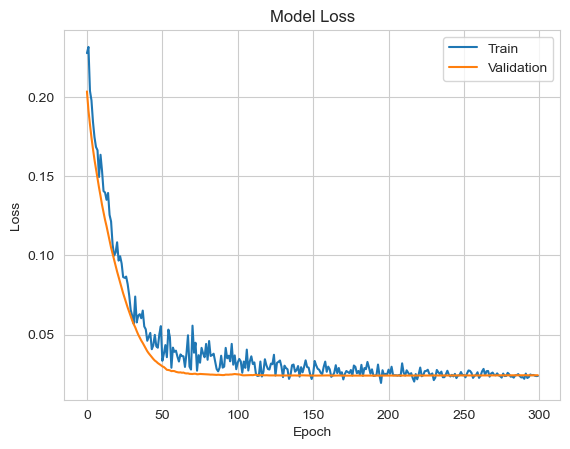

In [101]:
# Plot the training and validation loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

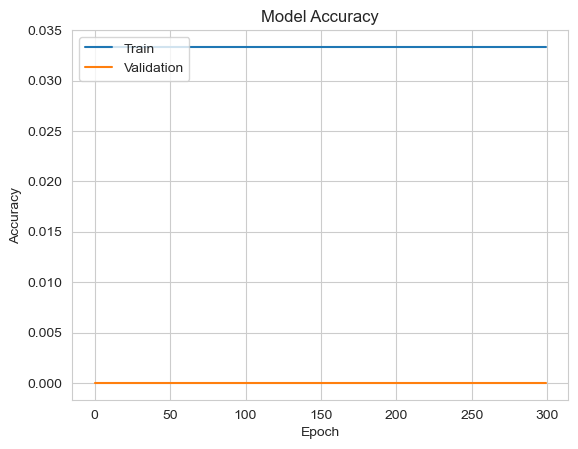

In [102]:
# Plot the training and validation accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [103]:
# Make predictions
train_predict = model.predict(train_X)
test_predict = model.predict(test_X)

1/1 [==============================] - 0s 16ms/step


In [104]:
# Inverse scaling for the predictions
train_predict = scaler.inverse_transform(train_predict)
train_Y = scaler.inverse_transform([train_Y])
test_predict = scaler.inverse_transform(test_predict)
test_Y = scaler.inverse_transform([test_Y])

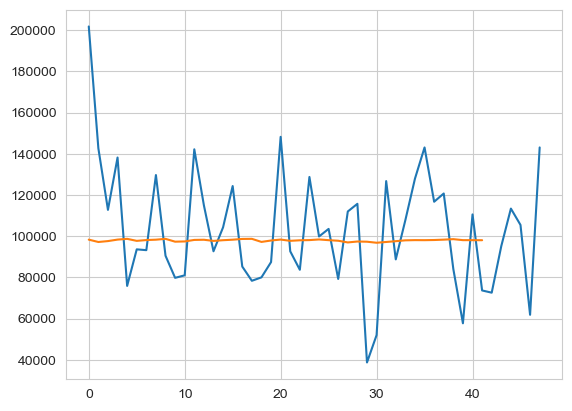

In [105]:
# Plot the results
plt.plot(temp_df['Sales'].values)
plt.plot(np.concatenate((train_predict,test_predict),axis=0))
plt.show()

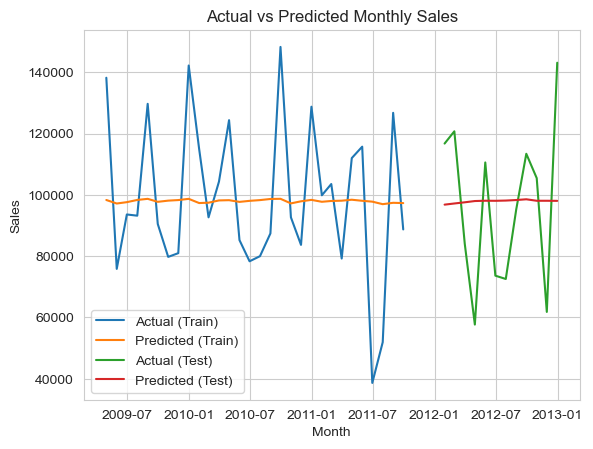

In [106]:
import numpy as np
import matplotlib.pyplot as plt

# Plotting the actual vs predicted values
train_dates = temp_df.index[look_back:train_size]
test_dates = temp_df.index[train_size + look_back:]
plt.plot(train_dates, train_Y.flatten(), label='Actual (Train)')
plt.plot(train_dates, train_predict.flatten(), label='Predicted (Train)')
plt.plot(test_dates, test_Y.flatten(), label='Actual (Test)')
plt.plot(test_dates, test_predict.flatten(), label='Predicted (Test)')



# Formatting the plot
plt.title('Actual vs Predicted Monthly Sales')
plt.xlabel('Month')
plt.ylabel('Sales')
plt.legend()
plt.show()


In [107]:
# Calculate the squared differences
squared_diff = (test_Y - test_predict) ** 2

# Calculate the mean squared differences
mean_squared_diff = np.mean(squared_diff)

# Calculate the RMSE
rmse = np.sqrt(mean_squared_diff)

# Print the RMSE
print("Root Mean Squared Error (RMSE):", rmse)

Root Mean Squared Error (RMSE): 25379.417868544486


*The dataset is too small with 30rows of training set and 12 rows of testing set, hence with such a small dataset, 
it is generally recommended to use simpler models that have fewer parameters and are less prone to overfitting. 
Complex models like deep neural networks, including LSTM, may struggle to generalize well with limited data*